In [2]:
import os, sys
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16
sys.path.append('../')
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from utils import acc_plot, loss_plot

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3)) # Include top = False, allow us to drop Dense layers

In [3]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Feature extraction
#### a) Conv layers are not trained at all

In [4]:
base_dir = 'cats_and_dogs'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [5]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0 
    # Remember that generator returns data infinitely - we need break statement
    for inputs_batch, labels_batch in generator:
        feature_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = feature_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [6]:
train_features, train_labels = extract_features(train_dir, 2000)
val_features, val_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


2023-03-09 16:21:14.340561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-09 16:21:18.238213: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 16:21:18.238246: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 0s 16ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 21ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 17ms/step


In [7]:
test_features.shape

(1000, 4, 4, 512)

In [8]:
train_features = np.reshape(train_features, (2000, 4*4*512))
val_features = np.reshape(val_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [9]:
test_features.shape

(1000, 8192)

In [10]:
model = Sequential([
    Dense(256, activation='relu', input_dim=4*4*512),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(val_features, val_labels))

Epoch 1/30


2023-03-09 16:21:48.718217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-09 16:21:48.720209: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55f0700c83e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-09 16:21:48.720226: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-03-09 16:21:48.724101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-09 16:21:48.808368: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 1s 4ms/step - loss: 0.4369 - accuracy: 0.8130 - val_loss: 0.2707 - val_accuracy: 0.8830
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2572 - accuracy: 0.8850 - val_loss: 0.2521 - val_accuracy: 0.8950
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1968 - accuracy: 0.9195 - val_loss: 0.2880 - val_accuracy: 0.8770
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1578 - accuracy: 0.9370 - val_loss: 0.2445 - val_accuracy: 0.8970
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1252 - accuracy: 0.9495 - val_loss: 0.2801 - val_accuracy: 0.8960
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1042 - accuracy: 0.9560 - val_loss: 0.2876 - val_accuracy: 0.8830
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1167 - accuracy: 0.9535 - val_loss: 0.3223 - val_accuracy: 0.8780
Epoch 8/30
100/10

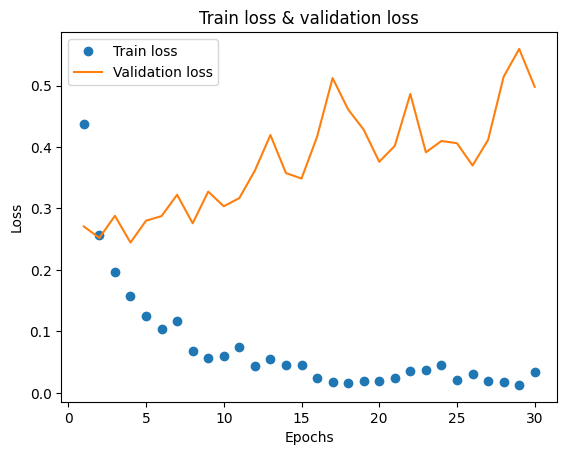

In [12]:
epochs = 30
history_dict = history.history
loss_plot(history_dict, epochs)

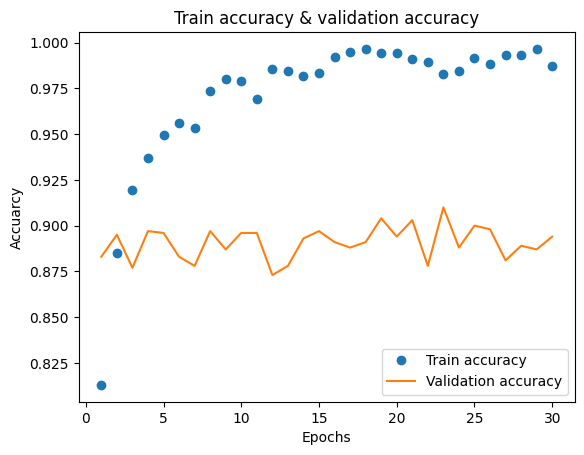

In [13]:
acc_plot(history_dict, epochs)

The loss is growing very quickly because we are not using data augmentation techniques.

#### b) Using data augmentation

In [14]:
model = Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Freezing a conv_base - weights won't be updated while training
print(len(model.trainable_weights))
conv_base.trainable = False
print(len(model.trainable_weights))

30
4


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,15),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# del model
# from keras import backend as K
# K.clear_session()

In [1]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=val_generator,
    validation_steps=50,
    verbose=2,
)
# approx 96% val accuracy

#### To make model even better we can defroze few conv layers

In [18]:
# block5_conv1, block5_conv2, block5_conv3 - will be trained
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
# model.compile
# model.fit ...

In [16]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.


In [18]:
# test_loss, test_acc = model.evaluate(test_generator)